(f_rs_crs)=


----------------

```{admonition} Learning Objectives
- Reproject remotely sensed data (change CRS)
- Reproject on-the-fly
- Compare resampling options
```
```{admonition} Review
* [What is a CRS](d_crs_what_is_it.md)
* [Understanding CRS codes](d_understand_crs_codes.md)
* [Raster CRS](d_raster_crs_intro.md)
```
----------------


# Remote Sensing Coordinate Reference Systems

Image projections can be transformed in GeoWombat using the configuration manager (see [Config Manager](f_rs_config.md)). With the configuration manager, the CRS is transformed using [rasterio CRS](https://rasterio.readthedocs.io/en/latest/api/rasterio.crs.html) and [virtual warping](https://rasterio.readthedocs.io/en/latest/topics/virtual-warping.html). For references, see [Spatial Reference](https://spatialreference.org/) and [epsg.io](http://epsg.io/).

## View Image Coordinate Reference System & Properties
In the following we will print out the properties relevant to CRS for the red, green blue image. The CRS can be accessed from the [xarray.DataArray](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html) attributes.

In [1]:
import geowombat as gw
from geowombat.data import rgbn

with gw.open(rgbn) as src:
    print(src.transform)
    print(src.gw.transform)
    print(src.crs)
    print(src.resampling)
    print(src.res)
    print(src.gw.cellx, src.gw.celly)

/home/mmann1123/miniconda3/envs/pygis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(5.0, 0.0, 792988.0, 0.0, -5.0, 2050382.0)
(5.0, 0.0, 792988.0, 0.0, -5.0, 2050382.0)
32618
nearest
(5.0, 5.0)
5.0 5.0


## Transforming a CRS (Reprojection)

To transform the CRS, use the context manager. In this example, a `proj4` code is used. See [understanding CRS codes](d_understand_crs_codes.md) for more details. We can pass the desired CRS as a `proj4` string, an EPSG code, or in authority:code `EPSG:4326` or `ESRI:53018`.

```{note}
Note the use of `nodata` in this case the file `rgbn` doesn't have the missing data value set in its profile, so we can set it manually when opened. 
```

(5.0, 0.0, 2502400.7632678417, 0.0, -5.0, -2147313.7330151177)
+proj=aea +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs +type=crs
nearest
(5.0, 5.0)


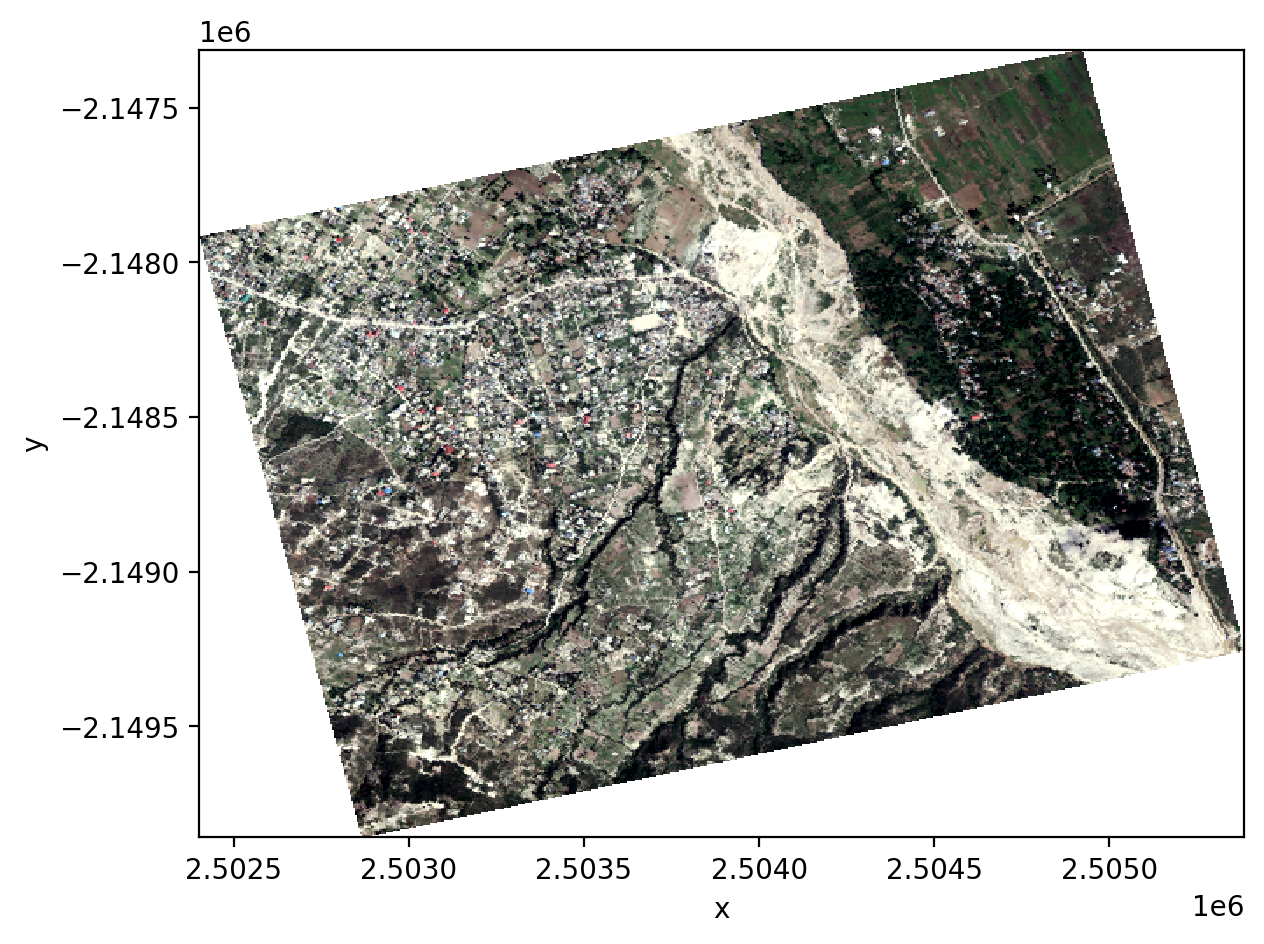

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi=200)

proj4 = "+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"

with gw.config.update(ref_crs=proj4):
    with gw.open(rgbn, nodata=0) as src:
        # replace 0 with nan
        src = src.gw.mask_nodata()
        print(src.transform)
        print(src.crs)
        print(src.resampling)
        print(src.res)
        src.sel(band=[3,2,1]).plot.imshow(robust=True, ax=ax)

plt.tight_layout(pad=1)

Other formats supported by rasterio, (e.g., PROJ4 strings) can be used. Here, we use a PROJ4 string to transform the CRS to a equal area projection.

In [3]:
with gw.config.update(ref_crs=32618):
    with gw.open(rgbn) as src:
        print(src.transform)
        print(src.crs)
        print(src.resampling)
        print(src.res)

(5.0, 0.0, 792988.0, 0.0, -5.0, 2050382.0)
32618
nearest
(5.0, 5.0)


## Resampling the Cell Size

Resampling cell size refers to the process of changing the spatial resolution of raster data. This can be done by either increasing or decreasing the size of the grid cells that make up the raster. There are different methods for resampling:

- `nearest`: Uses the value of the closest cell to assign a value to the output cell.
- `bilinear`: Uses the weighted average of the four nearest cells to determine the output cell value.
- `cubic`: Uses the weighted average of 16 nearest cells to determine the output value.

The resampling algorithm can be specified in the `geowombat.open` function. Here, we use cubic convolution resampling to warp the data to EPSG code 31972 (a UTM projection).

In [4]:
with gw.config.update(ref_crs=31972):
    with gw.open(rgbn, resampling='cubic') as src:
        print(src.transform)
        print(src.crs)
        print(src.resampling)
        print(src.res)

(5.0, 0.0, 792988.0000004865, 0.0, -5.0, 2050381.9999358936)
31972
cubic
(5.0, 5.0)


The transformed cell resolution can be added in the context manager. Here, we resample the data to 10m x 10m spatial resolution.

In [5]:
with gw.config.update(ref_crs=31972, ref_res=(10, 10)):
    with gw.open(rgbn, resampling='cubic') as src:
        print(src.transform)
        print(src.crs)
        print(src.resampling)
        print(src.res)

(10.0, 0.0, 792988.0000004865, 0.0, -10.0, 2050381.9999358936)
31972
cubic
(10.0, 10.0)


## Transformations Outside Context Manager

To transform an `xarray.DataArray` outside of a configuration context, use the `geowombat.transform_crs` function.

In [6]:
with gw.open(rgbn) as src:

    src_tr = src.gw.transform_crs(proj4, dst_res=(10, 10), resampling='bilinear')
    print(src_tr.transform)
    print(src_tr.crs)
    print(src_tr.resampling)
    print(src_tr.res)

(10.0, 0.0, 2502400.7632678417, 0.0, -10.0, -2147313.7330151177)
+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs +type=crs
bilinear
(10, 10)
